In [1]:
import numpy as np
from scipy.special import hankel1 as besselh
from scipy.special import iv as besseli
from scipy.special import kv as besselk
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from numpy import sqrt, cosh, cos, sinh, sin, pi, exp
from scipy.optimize import newton, minimize_scalar, root_scalar
import scipy as sp
from matplotlib.ticker import MultipleLocator


# from multi_constants_convergence_study import *
# from multi_equations_convergence_study import *
import pandas as pd
import time
import pickle

import capytaine as cpt
# from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force

In [2]:
############################################ SETTING UP VARIABLE ###############################################
m0_nums = np.concatenate((np.linspace(0.1, 1, 20), np.linspace(1, 6, 20)))

# # Mini Bicylinder
# h = 1.001
# d = [0.5, 0.25]
# a = [0.5, 1.0]
# heaving = [1, 1]

# # Small Bicylinder
# h = 20.0
# d = [10.0, 5.0]
# a = [5.0, 10.0]
# heaving = [1, 1]

# # Big Bicylinder
# h = 25.0
# d = [15.0, 10.0]
# a = [10.0, 15.0]
# heaving = [1, 1]

# # Mini Tricylinder
# h = 2.001
# d = [1.0, 0.5, 0.25]
# a = [0.25, 0.5, 1.0]
# heaving =[1, 1, 1]

# # Small Tricylinder
# h = 20.0
# d = [15, 10, 5]
# a = [5, 10, 15]
# heaving =[1, 1, 1]

# # Big Tricylinder
# h = 25.0
# d = [20, 15, 10]
# a = [10, 15, 20]
# heaving =[1, 1, 1]

# Some bicylinder
h = 1.001
d = [0.5, 0.25]
a = [0.25, 0.5]
heaving = [1, 1]

# m0 = 1.0/
g = 9.81
rho = 1023
NMK = [50, 50, 50]
####################################################

In [3]:
############################################## MEEM ############################################################
hydro_collector_real_MEEM = []
hydro_collector_imag_MEEM = []
hydro_nondim_real_diff = [np.nan]
hydro_nondim_imag_diff = [np.nan]
timing = []
loop_num = 0
# terms = range(2, 31)  # X-axis (index of elements)

for i in range(len(m0_nums)):
    m0 = m0_nums[i]
    start = time.time()
    
    ################MULTI_CONSTANTS#####################
    
    

    ################MULTI_EQUATIONS#####################
    omega = sqrt(m0 * np.tanh(m0 * h) * g)

    def wavenumber(omega):
        m0_err = (lambda m0: (m0 * np.tanh(h * m0) - omega ** 2 / g))
        return (root_scalar(m0_err, x0 = 2, method="newton")).root

    scale = np.mean([[0]+a[0:-1], a], axis = 0)

    def lambda_ni(n, i): # factor used often in calculations
        return n * pi / (h - d[i])

    #############################################
    # creating a m_k function, used often in calculations
    def m_k_entry(k):
        # m_k_mat = np.zeros((len(m0_vec), 1))
        if k == 0: return m0

        m_k_h_err = (
            lambda m_k_h: (m_k_h * np.tan(m_k_h) + m0 * h * np.tanh(m0 * h))
        )
        k_idx = k

        # # original version of bounds in python
        m_k_h_lower = pi * (k_idx - 1/2) + np.finfo(float).eps
        m_k_h_upper = pi * k_idx - np.finfo(float).eps
        # x_0 =  (m_k_upper - m_k_lower) / 2
        
        # # becca's version of bounds from MDOcean Matlab code
        # m_k_h_lower = pi * (k_idx - 1/2) + (pi/180)* np.finfo(float).eps * (2**(np.floor(np.log(180*(k_idx- 1/2)) / np.log(2))) + 1)
        # m_k_h_upper = pi * k_idx

        m_k_initial_guess = pi * (k_idx - 1/2) + np.finfo(float).eps
        result = root_scalar(m_k_h_err, x0=m_k_initial_guess, method="newton", bracket=[m_k_h_lower, m_k_h_upper])
        # result = minimize_scalar(
            # m_k_h_err, bounds=(m_k_h_lower, m_k_h_upper), method="bounded"
        # )

        m_k_val = result.root / h

        shouldnt_be_int = np.round(m0 * m_k_val / np.pi - 0.5, 4)
        # not_repeated = np.unique(m_k_val) == m_k_val
        assert np.all(shouldnt_be_int != np.floor(shouldnt_be_int))

            # m_k_mat[freq_idx, :] = m_k_vec
        return m_k_val

    # create an array of m_k values for each k to avoid recomputation
    m_k = (np.vectorize(m_k_entry, otypes = [float]))(list(range(NMK[-1])))

    def m_k_newton(h):
        res = newton(lambda k: k * np.tanh(k * h) - m0**2 / 9.8, x0=1.0, tol=10 ** (-10))
        return res

    #############################################
    # vertical eigenvector coupling computation

    def I_nm(n, m, i): # coupling integral for two i-type regions
        dj = max(d[i], d[i+1]) # integration bounds at -h and -d
        if n == 0 and m == 0:
            return h - dj
        lambda1 = lambda_ni(n, i)
        lambda2 = lambda_ni(m, i + 1)
        if n == 0 and m >= 1:
            if dj == d[i+1]:
                return 0
            else:
                return sqrt(2) * sin(lambda2 * (h - dj)) / lambda2
        if n >= 1 and m == 0:
            if dj == d[i]:
                return 0
            else:
                return sqrt(2) * sin(lambda1 * (h - dj)) / lambda1
        else:
            frac1 = sin((lambda1 + lambda2)*(h-dj))/(lambda1 + lambda2)
            if lambda1 == lambda2:
                frac2 = (h - dj)
            else:
                frac2 = sin((lambda1 - lambda2)*(h-dj))/(lambda1 - lambda2)
            return frac1 + frac2

    def I_mk(m, k, i): # coupling integral for i and e-type regions
        dj = d[i]
        if m == 0 and k == 0:
            if m0 * h < 14:
                return (1/sqrt(N_k(0))) * sinh(m0 * (h - dj)) / m0
            else: # high m0h approximation
                return sqrt(2 * h / m0) * (exp(- m0 * dj) - exp(m0 * dj - 2 * m0 * h))
        if m == 0 and k >= 1:
            return (1/sqrt(N_k(k))) * sin(m_k[k] * (h - dj)) / m_k[k]
        if m >= 1 and k == 0:
            if m0 * h < 14:
                num = (-1)**m * sqrt(2) * (1/sqrt(N_k(0))) * m0 * sinh(m0 * (h - dj))
            else: # high m0h approximation
                num = (-1)**m * 2 * sqrt(h * m0**3) *(exp(- m0 * dj) - exp(m0 * dj - 2 * m0 * h))
            denom = (m0**2 + lambda_ni(m, i) **2)
            return num/denom
        else:
            lambda1 = lambda_ni(m, i)
            if abs(m_k[k]) == lambda1:
                return (h - dj)/2
            else:
                frac1 = sin((m_k[k] + lambda1)*(h-dj))/(m_k[k] + lambda1)
                frac2 = sin((m_k[k] - lambda1)*(h-dj))/(m_k[k] - lambda1)
                return sqrt(2)/2 * (1/sqrt(N_k(k))) * (frac1 + frac2)
                
    #############################################
    # b-vector computation

    def b_potential_entry(n, i): # for two i-type regions
        #(integrate over shorter fluid, use shorter fluid eigenfunction)
        
        j = i + (d[i] < d[i+1]) # index of shorter fluid
        constant = (heaving[i+1] / (h - d[i+1]) - heaving[i] / (h - d[i]))
        if n == 0:
            return constant * 1/2 * ((h - d[j])**3/3 - (h-d[j]) * a[i]**2/2)
        else:
            return sqrt(2) * (h - d[j]) * constant * ((-1) ** n)/(lambda_ni(n, j) ** 2)

    def b_potential_end_entry(n, i): # between i and e-type regions
        constant = - heaving[i] / (h - d[i])
        if n == 0:
            return constant * 1/2 * ((h - d[i])**3/3 - (h-d[i]) * a[i]**2/2)
        else:
            return sqrt(2) * (h - d[i]) * constant * ((-1) ** n)/(lambda_ni(n, i) ** 2)

    def b_velocity_entry(n, i): # for two i-type regions
        if n == 0:
            return (heaving[i+1] - heaving[i]) * (a[i]/2)
        if d[i] > d[i + 1]: #using i+1's vertical eigenvectors
            if heaving[i]:
                num = - sqrt(2) * a[i] * sin(lambda_ni(n, i+1) * (h-d[i]))
                denom = (2 * (h - d[i]) * lambda_ni(n, i+1))
                return num/denom
            else: return 0
        else: #using i's vertical eigenvectors
            if heaving[i+1]:
                num = sqrt(2) * a[i] * sin(lambda_ni(n, i) * (h-d[i+1]))
                denom = (2 * (h - d[i+1]) * lambda_ni(n, i))
                return num/denom
            else: return 0

    def b_velocity_end_entry(k, i): # between i and e-type regions
        constant = - heaving[i] * a[i]/(2 * (h - d[i]))
        if k == 0:
            if m0 * h < 14:
                return constant * (1/sqrt(N_k(0))) * sinh(m0 * (h - d[i])) / m0
            else: # high m0h approximation
                return constant * sqrt(2 * h / m0) * (exp(- m0 * d[i]) - exp(m0 * d[i] - 2 * m0 * h))
        else:
            return constant * (1/sqrt(N_k(k))) * sin(m_k[k] * (h - d[i])) / m_k[k]

    #############################################
    # Phi particular and partial derivatives

    def phi_p_i(d, r, z): 
        return (1 / (2* (h - d))) * ((z + h) ** 2 - (r**2) / 2)

    def diff_r_phi_p_i(d, r, z): 
        return (- r / (2* (h - d)))

    def diff_z_phi_p_i(d, r, z): 
        return ((z+h) / (h - d))

    #############################################
    # The "Bessel I" radial eigenfunction
    def R_1n(n, r, i):
        if n == 0:
            return 0.5
        elif n >= 1:
            return besseli(0, lambda_ni(n, i) * r) / besseli(0, lambda_ni(n, i) * scale[i])
        else: 
            raise ValueError("Invalid value for n")

    # Differentiate wrt r
    def diff_R_1n(n, r, i):
        if n == 0:
            return 0
        else:
            top = lambda_ni(n, i) * besseli(1, lambda_ni(n, i) * r)
            bottom = besseli(0, lambda_ni(n, i) * scale[i])
            return top / bottom

    #############################################
    # The "Bessel K" radial eigenfunction
    def R_2n(n, r, i):
        if i == 0:
            raise ValueError("i cannot be 0")  # this shouldn't be called for i=0, innermost region.
        elif n == 0:
            return 0.5 * np.log(r / a[i])
        else:
            return besselk(0, lambda_ni(n, i) * r) / besselk(0, lambda_ni(n, i) * scale[i])


    # Differentiate wrt r
    def diff_R_2n(n, r, i):
        if n == 0:
            return 1 / (2 * r)
        else:
            top = - lambda_ni(n, i) * besselk(1, lambda_ni(n, i) * r)
            bottom = besselk(0, lambda_ni(n, i) * scale[i])
            return top / bottom


    #############################################
    # i-region vertical eigenfunctions
    def Z_n_i(n, z, i):
        if n == 0:
            return 1
        else:
            return np.sqrt(2) * np.cos(lambda_ni(n, i) * (z + h))

    def diff_Z_n_i(n, z, i):
        if n == 0:
            return 0
        else:
            lambda0 = lambda_ni(n, i)
            return - lambda0 * np.sqrt(2) * np.sin(lambda0 * (z + h))

    #############################################
    # Region e radial eigenfunction
    def Lambda_k(k, r):
        if k == 0:
            return besselh(0, m0 * r) / besselh(0, m0 * scale[-1])
        else:
            return besselk(0, m_k[k] * r) / besselk(0, m_k[k] * scale[-1])

    # Differentiate wrt r
    def diff_Lambda_k(k, r):
        if k == 0:
            numerator = -(m0 * besselh(1, m0 * r))
            denominator = besselh(0, m0 * scale[-1])
        else:
            numerator = -(m_k[k] * besselk(1, m_k[k] * r))
            denominator = besselk(0, m_k[k] * scale[-1])
        return numerator / denominator


    #############################################
    # Equation 2.34 in analytical methods book, also eq 16 in Seah and Yeung 2006:
    def N_k(k):
        if k == 0:
            return 1 / 2 * (1 + sinh(2 * m0 * h) / (2 * m0 * h))
        else:
            return 1 / 2 * (1 + sin(2 * m_k[k] * h) / (2 * m_k[k] * h))


    #############################################
    # e-region vertical eigenfunctions
    def Z_k_e(k, z):
        if k == 0:
            if m0 * h < 14:
                return 1 / sqrt(N_k(k)) * cosh(m0 * (z + h))
            else: # high m0h approximation
                return sqrt(2 * m0 * h) * (exp(m0 * z) + exp(-m0 * (z + 2*h)))
        else:
            return 1 / sqrt(N_k(k)) * cos(m_k[k] * (z + h))

    def diff_Z_k_e(k, z):
        if k == 0:
            if m0 * h < 14:
                return 1 / sqrt(N_k(k)) * m0 * sinh(m0 * (z + h))
            else: # high m0h approximation
                return m0 * sqrt(2 * h * m0) * (exp(m0 * z) - exp(-m0 * (z + 2*h)))
        else:
            return -1 / sqrt(N_k(k)) * m_k[k] * sin(m_k[k] * (z + h))

    #############################################
    # To calculate hydrocoefficients

    #integrating R_1n * r
    def int_R_1n(i, n):
        if n == 0:
            inner = (0 if i == 0 else a[i-1]) # central region has inner radius 0
            return a[i]**2/4 - inner**2/4
        else:
            lambda0 = lambda_ni(n, i)
            inner_term = (0 if i == 0 else a[i-1] * besseli(1, lambda0 * a[i-1])) # central region has inner radius 0
            top = a[i] * besseli(1, lambda0 * a[i]) - inner_term
            bottom = lambda0 * besseli(0, lambda0 * scale[i])
            return top / bottom

    #integrating R_2n * r
    def int_R_2n(i, n):
        if i == 0:
            raise ValueError("i cannot be 0")
        lambda0 = lambda_ni(n, i)
        if n == 0:
            return (a[i-1]**2 * (2*np.log(a[i]/a[i-1]) + 1) - a[i]**2)/8
        else:
            top = a[i] * besselk(1, lambda0 * a[i]) - a[i-1] * besselk(1, lambda0 * a[i-1])
            bottom = - lambda0 * besselk(0, lambda0 * scale[i])
            return top / bottom

    #integrating phi_p_i * d_phi_p_i/dz * r *d_r at z=d[i]
    def int_phi_p_i(i):
        denom = 16 * (h - d[i])
        if i == 0:
            num = a[i]**2*(4*(h-d[i])**2-a[i]**2)
        else:
            num = (a[i]**2*(4*(h-d[i])**2-a[i]**2) - a[i-1]**2*(4*(h-d[i])**2-a[i-1]**2))
        return num/denom

    # evaluate an interior region vertical eigenfunction at its top boundary
    def z_n_d(n):
        if n ==0:
            return 1
        else:
            return sqrt(2)*(-1)**n

    ####################################################
    #block_1: assertion
    boundary_count = len(NMK) - 1
    for arr in [a, d, heaving]:
        assert len(arr) == boundary_count, "NMK should have one more entry than a, d, and heaving, which should all have the same number of entries."

    for entry in heaving:
        assert (entry == 0 or entry == 1), "heaving entries should be booleans."

    left = 0
    for radius in a:
        assert radius > left, "a entries should be increasing, and start greater than 0."
        left = radius

    for depth in d:
        assert depth >= 0, "d entries should be nonnegative."
        assert depth < h, "d entries should be less than h."

    for val in NMK:
        assert (type(val) == int and val > 0), "NMK entries should be positive integers."

    assert (m0 >= 0), "m0 should be nonnegative." # currently shouldn't be 0 or too large, but that will be fixed eventually


    #block_2:
    # CREATING THE A MATRIX
    size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
    boundary_count = len(NMK) - 1

    rows = [] # collection of rows of blocks in A matrix, to be concatenated later

    ## Define values/functions to help block creation
    #Coupling integral values
    I_nm_vals = np.zeros((max(NMK), max(NMK), boundary_count - 1), dtype = complex)
    for bd in range(boundary_count - 1):
        for n in range(NMK[bd]):
            for m in range(NMK[bd + 1]):
                I_nm_vals[n][m][bd] = I_nm(n, m, bd)
    I_mk_vals = np.zeros((NMK[boundary_count - 1], NMK[boundary_count]), dtype = complex)
    for m in range(NMK[boundary_count - 1]):
        for k in range(NMK[boundary_count]):
            I_mk_vals[m][k]= I_mk(m, k, boundary_count - 1)

    ## Functions to create blocks of certain types
    # arguments: diagonal block on left (T/F), vectorized radial eigenfunction, boundary number
    def p_diagonal_block(left, radfunction, bd):
        region = bd if left else (bd + 1)
        sign = 1 if left else (-1)
        return sign * (h - d[region]) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))
        
    # arguments: dense block on left (T/F), vectorized radial eigenfunction, boundary number
    def p_dense_block(left, radfunction, bd):
        I_nm_array = I_nm_vals[0:NMK[bd],0:NMK[bd+1], bd]
        if left: # determine which is region to work in and which is adjacent
            region, adj = bd, bd + 1
            sign = 1
            I_nm_array = np.transpose(I_nm_array)
        else:
            region, adj = bd + 1, bd
            sign = -1
        radial_vector = radfunction(list(range(NMK[region])), a[bd], region)
        radial_array = np.outer((np.full((NMK[adj]), 1)), radial_vector)
        return sign * radial_array * I_nm_array

    def p_dense_block_e(bd):
        I_mk_array = I_mk_vals
        radial_vector = (np.vectorize(Lambda_k))(list(range(NMK[bd+1])), a[bd])
        radial_array = np.outer((np.full((NMK[bd]), 1)), radial_vector)
        return (-1) * radial_array * I_mk_array

    #####
    # arguments: diagonal block on left (T/F), vectorized radial eigenfunction, boundary number
    def v_diagonal_block(left, radfunction, bd):
        region = bd if left else (bd + 1)
        sign = (-1) if left else (1)
        return sign * (h - d[region]) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))

    # arguments: dense block on left (T/F), vectorized radial eigenfunction, boundary number
    def v_dense_block(left, radfunction, bd):
        I_nm_array = I_nm_vals[0:NMK[bd],0:NMK[bd+1], bd]
        if left: # determine which is region to work in and which is adjacent
            region, adj = bd, bd + 1
            sign = -1
            I_nm_array = np.transpose(I_nm_array)
        else:
            region, adj = bd + 1, bd
            sign = 1
        radial_vector = radfunction(list(range(NMK[region])), a[bd], region)
        radial_array = np.outer((np.full((NMK[adj]), 1)), radial_vector)
        return sign * radial_array * I_nm_array

    def v_diagonal_block_e(bd):
        return h * np.diag((np.vectorize(diff_Lambda_k))(list(range(NMK[bd+1])), a[bd]))

    def v_dense_block_e(radfunction, bd): # for region adjacent to e-type region
        I_km_array = np.transpose(I_mk_vals)
        radial_vector = radfunction(list(range(NMK[bd])), a[bd], bd)
        radial_array = np.outer((np.full((NMK[bd + 1]), 1)), radial_vector)
        return (-1) * radial_array * I_km_array


    #block_3
    # Potential Blocks
    col = 0
    for bd in range(boundary_count):
        N = NMK[bd]
        M = NMK[bd + 1]
        if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
            row_height = N
            left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
            right_block = p_dense_block_e(bd)
            if bd == 0: # one cylinder
                rows.append(np.concatenate((left_block1,right_block), axis = 1))
            else:
                left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
        elif bd == 0:
            left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
            if left_diag:
                row_height = N
                left_block = p_diagonal_block(True, np.vectorize(R_1n), 0)
                right_block1 = p_dense_block(False, np.vectorize(R_1n), 0)
                right_block2 = p_dense_block(False, np.vectorize(R_2n), 0)
            else:
                row_height = M
                left_block = p_dense_block(True, np.vectorize(R_1n), 0)
                right_block1 = p_diagonal_block(False, np.vectorize(R_1n), 0)
                right_block2 = p_diagonal_block(False, np.vectorize(R_2n), 0)
            right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
            block_lst = [left_block, right_block1, right_block2, right_zeros]
            rows.append(np.concatenate(block_lst, axis = 1))
            col += N
        else: # i-i boundary
            left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
            if left_diag:
                row_height = N
                left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                right_block1 = p_dense_block(False, np.vectorize(R_1n),  bd)
                right_block2 = p_dense_block(False, np.vectorize(R_2n),  bd)
            else:
                row_height = M
                left_block1 = p_dense_block(True, np.vectorize(R_1n),  bd)
                left_block2 = p_dense_block(True, np.vectorize(R_2n),  bd)
                right_block1 = p_diagonal_block(False, np.vectorize(R_1n),  bd)
                right_block2 = p_diagonal_block(False, np.vectorize(R_2n),  bd)
            left_zeros = np.zeros((row_height, col), dtype=complex)
            right_zeros = np.zeros((row_height, size - (col + 2 * N + 2 * M)),dtype=complex)
            block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
            rows.append(np.concatenate(block_lst, axis = 1))
            col += 2 * N


    ###############################
    # Velocity Blocks
    col = 0
    for bd in range(boundary_count):
        N = NMK[bd]
        M = NMK[bd + 1]
        if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
            row_height = M
            left_block1 = v_dense_block_e(np.vectorize(diff_R_1n, otypes=[complex]), bd)
            right_block = v_diagonal_block_e(bd)
            if bd == 0: # one cylinder
                rows.append(np.concatenate((left_block1,right_block), axis = 1))
            else:
                left_block2 = v_dense_block_e(np.vectorize(diff_R_2n, otypes=[complex]), bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
        elif bd == 0:
            left_diag = d[bd] < d[bd + 1] # taller fluid region gets diagonal entries
            if left_diag:
                row_height = N
                left_block = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0)
            else:
                row_height = M
                left_block = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0)
                right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0)
            right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
            block_lst = [left_block, right_block1, right_block2, right_zeros]
            rows.append(np.concatenate(block_lst, axis = 1))
            col += N
        else: # i-i boundary
            left_diag = d[bd] < d[bd + 1] # taller fluid region gets diagonal entries
            if left_diag:
                row_height = N
                left_block1 = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), bd)
                left_block2 = v_diagonal_block(True, np.vectorize(diff_R_2n, otypes=[complex]), bd)
                right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
                right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
            else:
                row_height = M
                left_block1 = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
                left_block2 = v_dense_block(True, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
                right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd)
                right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd)
            left_zeros = np.zeros((row_height, col), dtype=complex)
            right_zeros = np.zeros((row_height, size - (col + 2* N + 2 * M)),dtype=complex)
            block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
            rows.append(np.concatenate(block_lst, axis = 1))
            col += 2 * N

    ## Concatenate the rows of blocks into the square A matrix
    A = np.concatenate(rows, axis = 0)

    #block_4
    b = np.zeros(size, dtype=complex)

    index = 0

    # potential matching
    for boundary in range(boundary_count):
        if boundary == (boundary_count - 1): # i-e boundary
            for n in range(NMK[-2]):
                b[index] = b_potential_end_entry(n, boundary)
                index += 1
        else: # i-i boundary
            for n in range(NMK[boundary + (d[boundary] < d[boundary + 1])]): # iterate over eigenfunctions for smaller h-d
                b[index] = b_potential_entry(n, boundary)
                index += 1

    # velocity matching
    for boundary in range(boundary_count):
        if boundary == (boundary_count - 1): # i-e boundary
            for n in range(NMK[-1]):
                b[index] = b_velocity_end_entry(n, boundary)
                index += 1
        else: # i-i boundary
            for n in range(NMK[boundary + (d[boundary] > d[boundary + 1])]): # iterate over eigenfunctions for larger h-d
                b[index] = b_velocity_entry(n, boundary)
                index += 1

    #block_5
    X = linalg.solve(A,b)

    #block-6
    # The c-vector dotted with X is the hydro coefficient integral (+ a constant, sum(hydro_p_terms))
    c = np.zeros((size - NMK[-1]), dtype=complex)
    col = 0
    for n in range(NMK[0]):
        c[n] = heaving[0] * int_R_1n(0, n)* z_n_d(n)
    col += NMK[0]
    for i in range(1, boundary_count):
        M = NMK[i]
        for m in range(M):
            c[col + m] = heaving[i] * int_R_1n(i, m)* z_n_d(m)
            c[col + M + m] = heaving[i] * int_R_2n(i, m)* z_n_d(m)
        col += 2 * M

    hydro_p_terms = np.zeros(boundary_count, dtype=complex)
    for i in range(boundary_count):
        hydro_p_terms[i] = heaving[i] * int_phi_p_i(i)

    hydro_coef = 2 * pi * (np.dot(c, X[:-NMK[-1]]) + sum(hydro_p_terms))
    hydro_coef_real = hydro_coef.real * h**3 * rho
    hydro_coef_imag = hydro_coef.imag * omega * h**3 * rho

    # find maximum heaving radius
    max_rad = a[0]
    for i in range(boundary_count - 1, 0, -1):
        if heaving[i]:
            max_rad = a[i]
            break

    hydro_coef_nondim = h**3/(max_rad**3 * pi)*hydro_coef



    end = time.time()
    timing.append(end - start)

    hydro_collector_real_MEEM.append(hydro_coef_nondim.real)
    hydro_collector_imag_MEEM.append(hydro_coef_nondim.imag)

    if loop_num != 0:
        hydro_nondim_real_diff.append((hydro_collector_real_MEEM[loop_num]-hydro_collector_real_MEEM[loop_num-1])/hydro_collector_real_MEEM[loop_num-1])
        hydro_nondim_imag_diff.append((hydro_collector_imag_MEEM[loop_num]-hydro_collector_imag_MEEM[loop_num-1])/hydro_collector_imag_MEEM[loop_num-1])
    # if loop_num != 0:
    #     percent_diff_real = abs((186621534261.50247 - hydro_collector_real[loop_num-1])/186621534261.50247)
    #     percent_diff_imag = abs((3529258.9182286593 - hydro_collector_imag[loop_num-1])/3529258.9182286593)
    #     if percent_diff_real <= 0.001 and percent_diff_imag <= 0.001:
    #         break
    #     if timing[-1] > 11.94:
    #         break
    
    loop_num += 1



/var/folders/0t/y_xbnkt52g9fsyqjsmqsrnv40000gn/T/ipykernel_8125/3712730675.py:565: LinAlgWarning: Ill-conditioned matrix (rcond=7.37726e-27): result may not be accurate.
  X = linalg.solve(A,b)
/var/folders/0t/y_xbnkt52g9fsyqjsmqsrnv40000gn/T/ipykernel_8125/3712730675.py:565: LinAlgWarning: Ill-conditioned matrix (rcond=7.37725e-27): result may not be accurate.
  X = linalg.solve(A,b)
/var/folders/0t/y_xbnkt52g9fsyqjsmqsrnv40000gn/T/ipykernel_8125/3712730675.py:565: LinAlgWarning: Ill-conditioned matrix (rcond=7.37722e-27): result may not be accurate.
  X = linalg.solve(A,b)
/var/folders/0t/y_xbnkt52g9fsyqjsmqsrnv40000gn/T/ipykernel_8125/3712730675.py:565: LinAlgWarning: Ill-conditioned matrix (rcond=7.37719e-27): result may not be accurate.
  X = linalg.solve(A,b)
/var/folders/0t/y_xbnkt52g9fsyqjsmqsrnv40000gn/T/ipykernel_8125/3712730675.py:565: LinAlgWarning: Ill-conditioned matrix (rcond=7.37716e-27): result may not be accurate.
  X = linalg.solve(A,b)
/var/folders/0t/y_xbnkt52g9fsy

In [4]:
############################################## CAPYTAINE ############################################################

def body_from_profile(x,y,z,nphi):
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(x,y,z)])    # /sqrt(2) to account for the scaling
    body = cpt.FloatingBody(cpt.AxialSymmetricMesh.from_profile(xyz, nphi=nphi))
    return body

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    return body_from_profile(rarr, rarr, zarr, t_density)

def get_points(a, d): # These points define the outline of the body
    d_prime = d + [0]
    d_index = 0
    a_index = 0
    pt_lst = [(0, - d[0])]
    for i in range(len(a)):
        pt_lst.append((a[a_index], - d_prime[d_index]))
        d_index +=1
        pt_lst.append((a[a_index], - d_prime[d_index]))
        a_index+=1
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = abs(p2[0] - p1[0]) + abs(p2[1] - p1[1]) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities
    
def make_body(a, d, heaving, t_densities, face_units): 
    pts = get_points(a,d)
    f_densities = get_f_densities(pts, face_units)
    faces_and_heaves = []
    panel_ct = 0
    for i in range((len(pts) - 1) // 2):
        p1, p2, p3 = pts[2 * i], pts[2 * i + 1], pts[2 * i + 2]
        # make a horizontal face
        h_face = make_face(p1, p2, f_densities[2 * i], t_densities[i])
        h_heave = heaving[i]
        faces_and_heaves.append((h_face, h_heave))
        panel_ct += f_densities[2 * i] * t_densities[i]
        # make a vertical face
        if p2[1] < p3[1]: # body on left
            region = i
        else: # body on right
            region = i + 1
        v_face = make_face(p2, p3, f_densities[2 * i + 1], t_densities[region])
        faces_and_heaves.append((v_face, heaving[region]))
        panel_ct += f_densities[2 * i + 1] * t_densities[region]
    body = add_heaves(faces_and_heaves)
    return body, panel_ct
    

def add_heaves(faces_and_heaves):
    hcreate = False
    screate = False
    for fh in faces_and_heaves: # Splits list of faces into those that are heaving and those that are not.
        if fh[1]: #fh of the form (face, heaving)
            if not hcreate:
                heaving_body = fh[0]
                hcreate = True
            else:
                heaving_body = heaving_body + fh[0]
        else:
            if not screate:
                still_body = fh[0]
                screate = True
            else:
                still_body = still_body + fh[0]
    if hcreate: # Adds heave dof to the heaving collection
        heaving_body.add_translation_dof(name='Heave')
        if screate:
            return (heaving_body + still_body)
        else:
            return (heaving_body)
    else:
        return (still_body)

###################################
# Solving
solver = cpt.BEMSolver()

def rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho):
    body, panel_count = make_body(a, d, heaving, t_densities, face_units)
    body = body.immersed_part() # removes points above z = 0
    # body.show_matplotlib()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    results = solver.solve(rad_problem, keep_details = True)

    rho = 1023 # density of our special material
    wave_amp = 1
    g = 9.81
    omega = np.sqrt(m0*np.tanh(m0*h)*g)

    A = np.array(list(results.added_mass.values()))
    B = np.array(list(results.radiation_damping.values()))
    A_nondim = h**3 / (rho * np.pi * max(a)**3) * A
    B_nondim = h**3 / (omega * rho * np.pi * max(a)**3) * B
    # print(results.added_mass)
    # print(type(results.added_mass))
    # print(results.radiation_damping)
    print("# of Panels: ", panel_count)
    # return A, B, A_nondim, B_nondim
    return A, B, A_nondim, B_nondim

t_densities = [50, 50] # number of panels around each cylinder
face_units = 50 # number of panels along the outline of the configuration
results = [rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho) for m0 in m0_nums]

hydro_collector_real_CPT = [res[2].flatten() for res in results]
hydro_collector_imag_CPT = [res[3].flatten() for res in results]


/Users/enlo/miniconda3/envs/MEEM/lib/python3.10/site-packages/capytaine/bem/solver.py:128: RuntimeWarning: divide by zero encountered in matmul
  potential = S @ sources
/Users/enlo/miniconda3/envs/MEEM/lib/python3.10/site-packages/capytaine/bem/solver.py:128: RuntimeWarning: overflow encountered in matmul
  potential = S @ sources
/Users/enlo/miniconda3/envs/MEEM/lib/python3.10/site-packages/capytaine/bem/solver.py:128: RuntimeWarning: invalid value encountered in matmul
  potential = S @ sources


# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500


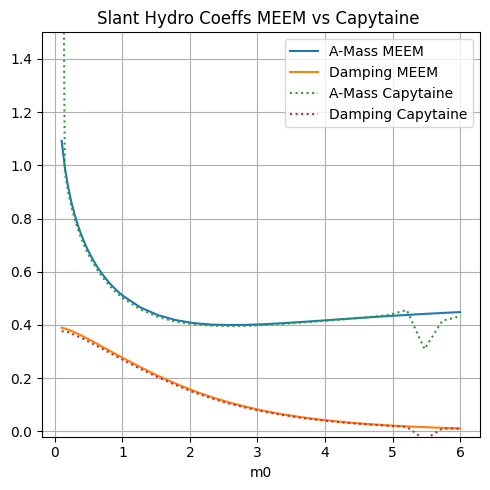

In [5]:
# Create the plots
plt.figure(figsize=(5,5))
plt.plot(m0_nums, hydro_collector_real_MEEM, label='A-Mass MEEM', linestyle='-')
plt.plot(m0_nums, hydro_collector_imag_MEEM, label='Damping MEEM', linestyle='-')
plt.plot(m0_nums, hydro_collector_real_CPT, label='A-Mass Capytaine',  linestyle=':')
plt.plot(m0_nums, hydro_collector_imag_CPT, label='Damping Capytaine',  linestyle=':') 

plt.xlabel('m0')
plt.ylabel('')
plt.title('Slant Hydro Coeffs MEEM vs Capytaine ')
plt.legend(loc='best')
plt.grid(True)
plt.ylim(-0.02, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
###graphing time, difference, and added mass###
ticks = np.arange(0, 31, 2)
# Create the plots
plt.figure(figsize=(10, 8))

# Plot real parts
plt.subplot(5, 1, 1)  # 1 row, 2 columns, first plot
plt.plot(range(terms[0], terms[0]+loop_num), hydro_collector_real, 'bo-', markersize=2, label='Added Mass')
plt.xlabel('Number of Terms')
plt.xticks(ticks, fontsize=9)
# plt.ylabel('Added Mass (Nondimensional)')
plt.title('Added Mass (Nondimensional)')
# plt.axhline(y=0.57774782, color='purple', linestyle='--', label='Capytaine Value')
plt.legend()
plt.grid(True)

# Plot the difference
# returns the index of the first value difference < 0.001, or None if there isn’t one
idx = next((i for i, v in enumerate(hydro_nondim_real_diff) if np.abs(v) < 0.001), None)
plt.subplot(5, 1, 2)  # 1 row, 2 columns, second plot
plt.plot(range(terms[0], terms[0]+loop_num), hydro_nondim_real_diff, 'ro-', markersize=2, label='% Difference')
plt.axvline(x=terms[idx],color='purple', linestyle='--', label='difference less than 0.001')
plt.xlabel('Number of Terms')
plt.xticks(ticks, fontsize=9)
# plt.ylabel('%Difference')
plt.title('% Add Mass Difference to the Previous One')
plt.legend(loc='upper right')
plt.grid(True)

# Plot imag parts
plt.subplot(5, 1, 3)  # 1 row, 2 columns, first plot
plt.plot(range(terms[0], terms[0]+loop_num), hydro_collector_imag, 'bo-', markersize=2, label='Damping')
plt.xlabel('Number of Terms')
plt.xticks(ticks, fontsize=9)
# plt.ylabel('Added Mass (Nondimensional)')
plt.title('Damping (Nondimensional)')
# plt.axhline(y=0.19735159, color='purple', linestyle='--',label='Capytaine Value')
plt.legend()
plt.grid(True)

# Plot the difference
idx = next((i for i, v in enumerate(hydro_nondim_imag_diff) if np.abs(v) < 0.001), None)
plt.subplot(5, 1, 4)  # 1 row, 2 columns, second plot
plt.plot(range(terms[0], terms[0]+loop_num), hydro_nondim_imag_diff, 'ro-', markersize=2, label='% Difference')
plt.axvline(x=terms[idx],color='purple', linestyle='--', label='difference less than 0.001')
plt.xlabel('Number of Terms')
plt.xticks(ticks, fontsize=9)
# plt.ylabel('%Difference')
plt.title('% Damping Difference to the Previous One')
plt.legend(loc='upper right')
plt.grid(True)

# Plot running time
plt.subplot(5, 1, 5)  # 1 row, 2 columns, second plot
plt.plot(range(terms[0], terms[0]+loop_num), timing, 'go-', markersize=2, label='Running time')
plt.xlabel('Number of Terms')
plt.xticks(ticks, fontsize=9)
# plt.ylabel('Time it takes (sec)')
plt.title('Time it takes (sec)')
plt.legend()
plt.grid(True)




# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
print(1/285)

In [ ]:
####printing the hydro-coefficients and converting them into MATLAB format###
print(hydro_collector_real)
print(hydro_collector_imag)

matlab_list1 = "pyMEEM_mu_nondim = [" + " ".join(map(str, hydro_collector_real)) + "];"
matlab_list2 = "pyMEEM_lambda_nondim = [" + " ".join(map(str, hydro_collector_imag)) + "];"

# Print MATLAB code
print(matlab_list1)
print(matlab_list2)

In [ ]:
print(hydro_collector_real[0])
print(hydro_collector_imag[0])



In [ ]:


# Create the plots
plt.figure(figsize=(10, 5))

# Plot real parts
plt.subplot(3, 1, 1)  # 1 row, 2 columns, first plot
plt.plot(range(terms[0], terms[0]+loop_num+1), hydro_collector_real, 'bo-', markersize=2, label='Real Part')
plt.xlabel('Number of Terms')
plt.ylabel('Real Value')
plt.title('Real Part of Complex Numbers')
plt.legend()
plt.grid(True)

# Plot imaginary parts
plt.subplot(3, 1, 2)  # 1 row, 2 columns, second plot
plt.plot(range(terms[0], terms[0]+loop_num+1), hydro_collector_imag, 'ro-', markersize=2, label='Imaginary Part')
plt.xlabel('Number of Terms')
plt.ylabel('Imaginary Value')
plt.title('Imaginary Part of Complex Numbers')
plt.legend()
plt.grid(True)

# Plot running time
plt.subplot(3, 1, 3)  # 1 row, 2 columns, second plot
plt.plot(range(terms[0], terms[0]+loop_num+1), timing, 'go-', markersize=2, label='Running time')
plt.xlabel('Number of Terms')
plt.ylabel('Time it takes (sec)')
plt.title('Time it takes (sec)')
plt.legend()
plt.grid(True)



# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
with open("h50_ii2i_conv_data.pkl", "wb") as f:
    pickle.dump((hydro_collector_real, hydro_collector_imag, timing), f)

In [ ]:
# with open("h50_convergence_data.pkl", "rb") as f:
#     real_h50, imag_h50, timing_h50 = pickle.load(f)

# with open("h51_convergence_data.pkl", "rb") as f:
#     real_h51, imag_h51, timing_h51 = pickle.load(f)

# with open("h52_convergence_data.pkl", "rb") as f:
#     real_h52, imag_h52, timing_h52 = pickle.load(f)

# with open("h53_convergence_data.pkl", "rb") as f:
#     real_h53, imag_h53, timing_h53 = pickle.load(f)

# with open("h54_convergence_data.pkl", "rb") as f:
#     real_h54, imag_h54, timing_h54 = pickle.load(f)

# with open("h55_convergence_data.pkl", "rb") as f:
#     real_h55, imag_h55, timing_h55 = pickle.load(f)

# with open("h56_convergence_data.pkl", "rb") as f:
#     real_h56, imag_h56, timing_h56 = pickle.load(f)

# with open("h35_convergence_data.pkl", "rb") as f:
#     real_h35, imag_h35, timing_h35 = pickle.load(f)

# with open("h65_convergence_data.pkl", "rb") as f:
#     real_h65, imag_h65, timing_h65 = pickle.load(f)

# with open("h80_convergence_data.pkl", "rb") as f:
#     real_h80, imag_h80, timing_h80 = pickle.load(f)

In [ ]:
with open("h50_iii_conv_data.pkl", "rb") as f:
    real_h50_iii, imag_h50_iii, timing_h50_iii = pickle.load(f)

with open("h50_i2ii_conv_data.pkl", "rb") as f:
    real_h50_i2ii, imag_h50_i2ii, timing_h50_i2ii = pickle.load(f)

with open("h50_i3ii_conv_data.pkl", "rb") as f:
    real_h50_i3ii, imag_h50_i3ii, timing_h50_i3ii = pickle.load(f)

with open("h50_i4ii_conv_data.pkl", "rb") as f:
    real_h50_i4ii, imag_h50_i4ii, timing_h50_i4ii = pickle.load(f)

with open("h50_2i2ii_conv_data.pkl", "rb") as f:
    real_h50_2i2ii, imag_h50_2i2ii, timing_h50_2i2ii = pickle.load(f)

with open("h50_2ii2i_conv_data.pkl", "rb") as f:
    real_h50_2ii2i, imag_h50_2ii2i, timing_h50_2ii2i = pickle.load(f)

with open("h50_i2i2i_conv_data.pkl", "rb") as f:
    real_h50_i2i2i, imag_h50_i2i2i, timing_h50_i2i2i = pickle.load(f)

with open("h50_i3i3i_conv_data.pkl", "rb") as f:
    real_h50_i3i3i, imag_h50_i3i3i, timing_h50_i3i3i = pickle.load(f)

with open("h50_ii2i_conv_data.pkl", "rb") as f:
    real_h50_ii2i, imag_h50_ii2i, timing_h50_ii2i = pickle.load(f)

In [ ]:
plt.scatter(timing_h50_iii, real_h50_iii, label='i,i,i')
plt.scatter(timing_h50_ii2i, real_h50_ii2i, label='i,i,2i')
plt.scatter(timing_h50_i2ii, real_h50_i2ii, label='i,2i,i')
plt.scatter(timing_h50_i3ii, real_h50_i3ii, label='i,3i,i')
plt.scatter(timing_h50_i4ii, real_h50_i4ii, label='i,4i,i')
plt.scatter(timing_h50_2i2ii, real_h50_2i2ii, label='2i,2i,i')
plt.scatter(timing_h50_2ii2i, real_h50_2ii2i, label='2i,i,2i')
plt.scatter(timing_h50_i2i2i, real_h50_i2i2i, label='i,2i,2i')
plt.scatter(timing_h50_i3i3i, real_h50_i3i3i, label='i,3i,3i')
plt.axhline(y=186621534261.50247, color='r', linestyle='--')
plt.xlabel('running time')
plt.ylabel('hydro_real')
plt.title('hydro_real, iii comparison (h=50)')

plt.legend()
plt.show()

In [ ]:
plt.scatter(timing_h50_iii, imag_h50_iii, label='i,i,i')
plt.scatter(timing_h50_ii2i, imag_h50_ii2i, label='i,i,2i')
plt.scatter(timing_h50_i2ii, imag_h50_i2ii, label='i,2i,i')
plt.scatter(timing_h50_i3ii, imag_h50_i3ii, label='i,3i,i')
plt.scatter(timing_h50_i4ii, imag_h50_i4ii, label='i,4i,i')
plt.scatter(timing_h50_2i2ii, imag_h50_2i2ii, label='2i,2i,i')
plt.scatter(timing_h50_2ii2i, imag_h50_2ii2i, label='2i,i,2i')
plt.scatter(timing_h50_i2i2i, imag_h50_i2i2i, label='i,2i,2i')
plt.scatter(timing_h50_i3i3i, imag_h50_i3i3i, label='i,3i,3i')
plt.axhline(y=3529258.9182286593, color='r', linestyle='--')

plt.xlabel('running time')
plt.ylabel('hydro_imag')
plt.title('hydro_imag, iii comparison (h=50)')

plt.legend()
plt.show()

In [ ]:
print(hydro_collector_real)
print(hydro_collector_imag)

In [ ]:
W = [1,2,3]
print(sum(W))


In [ ]:
########YEUNG MULTIPLICATION HYDRO-COEFF CALCULATION#######
    # hydro_coef_1_1 = (4*(h-d[0])**2-a[0]**2)/(8*a[0]*(h-d[0]))+X[0]/a[0]
    # W_1 = np.zeros(NMK[0]+1, dtype=complex)
    # for n in range(1,NMK[0]):
    #     W_1[n] = X[n]*(-1)**n*besseli(1,lambda_ni(n, 0)*a[0])/(lambda_ni(n,0)*besseli(0,lambda_ni(n,0)*a[0]))
    # hydro_coef_1_2 = (2/a[0]**2)*sum(W_1)
    # hydro_coef_2_1 = (a[1]**2-a[0]**2)**2/(8*a[1]**3)/(h-d[1])*(4*(h-d[1])**2-(a[1]**2+a[0]**2))
    # hydro_coef_2_2 = X[NMK[0]]*(a[1]**2-a[0]**2)/(2*a[1]**3)
    # hydro_coef_2_3 = X[NMK[0]+NMK[1]]/(2*a[1]**3)*(a[1]**2*np.log(a[1])-a[0]**2*np.log(a[0])-(a[1]**2-a[0]**2)/2)
    # W_2 = np.zeros(NMK[1]+1, dtype=complex)
    # for m in range(1,NMK[1]):
    #     W_2[m] = (-1)**m/lambda_ni(m, 1)*(X[NMK[0]+m]*(a[1]*besseli(1,lambda_ni(m, 1)*a[1])/besseli(0,lambda_ni(m,1)*scale) -a[0]*besseli(1,lambda_ni(m,1)*a[0])/besseli(0,lambda_ni(m,1)*scale))
    #                                      -X[NMK[0]+NMK[1]+m]*(a[1]*besselk(1,lambda_ni(m, 1)*a[1])/besselk(0,lambda_ni(m,1)*scale) -a[0]*besselk(1,lambda_ni(m,1)*a[0])/besselk(0,lambda_ni(m,1)*scale)))
    # hydro_coef_2_4 = (2/a[1]**3)*sum(W_2)

    # hydro_coef = hydro_coef_1_1 + hydro_coef_1_2 + hydro_coef_2_1 + hydro_coef_2_2 + hydro_coef_2_3 + hydro_coef_2_4
    # hydro_coef_real = hydro_coef.real
    # hydro_coef_imag = hydro_coef.imag/omega

    ###############